# Classification using Heart Disease Data Set

This notebook compares the different classification techniques of a logistic regression model, a support vector machine model, and a 3-layer neural network that uses a sigmoid activator in Python on a Heart Disease dataset that has the outcome being classified as having heart disease (indicated by a "1") or not (indicates by a "0"). 

Since many models are being compared, a train, validate, test split will be used with a respective split of 60%, 20%, and 20%. Performance will be assessed by comparing accuracy and F1 scores.

More information about the dataset is under **The Data Source** section.Now to load the libraries and data.

In [1]:
import pandas as pd
import researchpy as rp
import numpy as np

from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split # Fast way for splitting data into train, validate, and test sets
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')

In [2]:
#df = pd.read_csv("C:\\Users\\CoreySSD\\Downloads\\heart.csv")
df = pd.read_csv("C:\\Users\\bryantcm\\Downloads\\heart.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


### The Data Source

The data is from [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) and was uploaded by the user <i>ronit</i>. The data contains attributes, that are a subset from a larger database, that are believed to predict the presence of heart disease. The variables in the data are:

* *age* = patients age
* *sex* = patients sex (1 = male, 0 = female)
* *cp* = chest pain type
    * 1 indicates typical angina
    * 2 indicates atypical angina
    * 3 indicates non-anginal pain
    * 4 indicates asympotmatic
* *trestbps* = resting blood pressure (measured in mm/Hg at time of hospital admission)
* *chol* = serum cholestoral measured in mh/dl
* *fbs* = fasting blood sugar (1 = fbs > 120 mg/dl, 0 = fbs &le; 120 mg/dl)
* *restecg* = resting electrocardiographic results
    * 0 indicates normal results
    * 1 indicates having ST-T wave abnormality (T wave inversion and/or ST elevation or depression of > 0.05 mV)
    * 2 indicates showing probable or definite left ventricular hypertrophy using the Estes' criteria
* *thalach* = maximum heart rate achieved
* *exang* = exercise induced angina (1 = yes, 0 = no)
* *oldpeak* = ST depression induced by exercise relative to rest
* *slope* = the slope of the peak exercise ST segment
    * 1 indicates upsloping
    * 2 indicates flat
    * 3 indicate downsloping
* *ca* = number of major vessels (0-3) colored by flourosopy
* *thal* = (no description provided; 3 = normal, 6 = fixed defect, 7 = reversable defect)
* *target* = presence of heart disease (1 = yes, 0 = no; 1 is the collapsed measure of any level of heart disease which typically ranges on a measure from 0-4 where 0 indicates no heart disease present)

In [3]:
# Getting some information on the continuous variables

rp.summary_cont(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,age,303.0,54.366337,9.082101,0.521753,53.339605,55.393069
1,trestbps,303.0,131.623762,17.538143,1.007540,129.641075,133.606450
2,chol,303.0,246.264026,51.830751,2.977599,240.404558,252.123495
3,thalach,303.0,149.646865,22.905161,1.315867,147.057435,152.236294
4,oldpeak,303.0,1.039604,1.161075,0.066702,0.908344,1.170864
5,ca,303.0,0.729373,1.022606,0.058747,0.613767,0.844979


In [4]:
# Getting some information on the categorical variables
rp.summary_cat(df[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', \
                   'ca', 'thal', 'target']])

,Variable,Outcome,Count,Percent
0,sex,1,207,68.32
1,,0,96,31.68
2,cp,0,143,47.19
3,,2,87,28.71
4,,1,50,16.50
5,,3,23,7.59
6,fbs,0,258,85.15
7,,1,45,14.85
8,restecg,1,152,50.17
9,,0,147,48.51


There is a pretty even split of those with heart disease, 54.5%, and those without heart disease, 45.5%. Next, to split the data into our feature set and the outcome set.

In [5]:
features = df.iloc[:, :-1]
target = df['target']

### Feature Normalization
The features are measured on different scales and have a range of variation present. This is a good case to normalize the features to remove the scale units from the measurement. I will use feature standardization method, this can be expressed using the following formula:

$$
x'= \frac{x - average(x)}{\sigma}
$$

In [6]:
def feature_normalization(x):
    x_prime = (x - x.mean()) / x.std()
    
    return x_prime

In [7]:
features_norm = features.apply(feature_normalization)

### Splitting the Data 
When splitting data it is best practice to split the data randomly. Scikit learn has a built-in method that allows the data to be split into train and test sets, but doesn't include the splitting into a validation set. It's an easy fix, just have to run the method twice.

The data will be split into a 60% train, 20% validate, and 20% test.

In [8]:
# The first spit - 60% train and 40% test
features_train, features_test, target_train, target_test \
    = train_test_split(features_norm, target, test_size=0.4, random_state=1)

# The second split - 20% validate and 20% test
features_validate, features_test, target_validate, target_test \
    = train_test_split(features_test, target_test, 
                       test_size=0.5, random_state=1)

print("Regular data set length=", features.shape[0], "\n", 
      "Feature training set length=", features_train.shape[0], f"which is{features_train.shape[0]/features.shape[0]*100: .0f}% of the original", "\n",
     "Feature validate set length=", features_validate.shape[0], f"which is{features_validate.shape[0]/features.shape[0]*100: .0f}% of the original", "\n",
     "Feature test set length=", features_test.shape[0], f"which is{features_test.shape[0]/features.shape[0]*100: .0f}% of the original", "\n",)

Regular data set length= 303 
 Feature training set length= 181 which is 60% of the original 
 Feature validate set length= 61 which is 20% of the original 
 Feature test set length= 61 which is 20% of the original 



## Logistic Regression Model

This logistic regression model will use the *newton-cg* solver with the default regularization penalty *l2*.

In [9]:
classifier = LogisticRegression(random_state= 1, solver= 'newton-cg')
classifier.fit(features_train, target_train)

LogReg_y_predict = classifier.predict(features_test)
LogReg_accuracy = accuracy_score(target_validate, classifier.predict(features_validate))
LogReg_f1_score = f1_score(target_validate, classifier.predict(features_validate))

print("Using a Logistic Regression model, the accuracy achieved on the validation set",
      f"was {LogReg_accuracy*100: 0.1f}% and the f1 score was {LogReg_f1_score}.")

Using a Logistic Regression model, the accuracy achieved on the validation set was  80.3% and the f1 score was 0.8125.


## SVM Model
There are various kernals that can be used in the support vector machine algorithms. Scikit learn accepts the kernal options of: 'rbf' (the default), 'linear', 'poly', 'sigmoid', 'precomputed', or a callable function that the user created. With the outcome being binary, I will use the sigmoid function and test varying penalization parameters of C and gamma.

### Setting up the SVM Model
There are a couple parameters that need to be decided on when using a support vector machine, the parameter *C and gamma*. Finding a good combination of these can be tricky, but they each effect the model's bias and variance. Easy way to test the combined effect of this is to use a for loop and compare accuracy metrics. In general: <br>

**The C parameter** <br>
This parameter is a penality parameter that is applied to the formula. A value of 1 means no penality
> Large C value = lower bias and higher variance (more prone to overfitting) <br>
> Small C value = higher bias and low variance (more prone to underfitting)

**The gamma parameter** <br>
By default, scikit learn svm uses $\frac{1}{\text{# of features * $\sigma$}}$. This parameter effect the smoothness and overall shape of the peak of the data.

In [10]:
clf = svm.SVC(gamma= 'scale', 
              C= 1, kernel= 'sigmoid', 
              max_iter= 3000)
clf.fit(features_train, target_train)

SVM_accuracy = accuracy_score(target_validate, clf.predict(features_validate))
SVM_f1_score = f1_score(target_validate, clf.predict(features_validate))

print("Using a SVM model, the accuracy achieved on the validation set",
      f"was {SVM_accuracy*100: 0.1f}% and \nthe f1 score was {SVM_f1_score}.")

Using a SVM model, the accuracy achieved on the validation set was  80.3% and 
the f1 score was 0.8181818181818182.


The initial model achieved an accuracy of 80.3% with an F1 score of 0.82. Since the penalization parameter effects the cost of the function, I will test multiple C values and opt to use the best performing C value, in terms of accuracy and F1 score, in the final model selection. C values with an accuracy score $\ge$ 80% will be displayed, and of those the best performing F1 score will be used to select the model for comparison against the logistic regression model and the 3-layer neural network.

In [11]:
c = np.linspace(0.001, 30, num= 100)
accuracy = {}
f1 = {}

for penality in c:
    clf = svm.SVC(gamma= 'scale', 
                  C= penality, 
                  kernel= 'sigmoid', 
                  max_iter= 3000)
    clf.fit(features_train, target_train)
        
    acc = accuracy_score(target_validate, clf.predict(features_validate))
    f1_sc = f1_score(target_validate, clf.predict(features_validate))
        
    if acc >= 0.80000000:
        accuracy.update({penality: acc})
        f1.update({penality: f1_sc})
            

max_acc_value = max(accuracy.values())
max_key = [key for key, value in accuracy.items() if value == max_acc_value]

good_f1_values = [(value, key) for key, value in f1.items()]
max_f1_value = max(good_f1_values)

print(f"The C values that produced the largest accuracy score of {max_acc_value*100: 0.1f}%",
      f"were: {max_key}. Of those C values, the best f1 score was {max_f1_value[0]}", 
      f"which was associated with the C value of {max_f1_value[1]}")

The C values that produced the largest accuracy score of  82.0% were: [24.84865656565657, 26.060737373737375, 27.272818181818185, 27.575838383838384, 27.878858585858588]. Of those C values, the best f1 score was 0.819672131147541 which was associated with the C value of 24.84865656565657


There are several C values that produced accuracy scores that were greater than 80% - albeit not that much greater. More specifically, there were 5 C values that produced the maximum accuracy score of 82%. Of those C values, the best f1 score that was achieved corresponded to C = 24.85.

# Neural Network

Here I will test a 3 layer neural network model on the data to see if it performs better than both the logistic regression and SVM models. In this neural network, I will use the sigmoid function as the activator again since the outcome is binary.

In [12]:
x_train = features_train.values # Converting Pandas Data Frame into Matrix
x_train = np.append(np.ones([len(x_train), 1]), x_train, 1) # Adding bias paramter

y_train = np.matrix(target_train) # Converting Pandas Data Frame into Matrix
yVec_train = y_train.reshape((181,1)) # Reshape Marix

In [13]:
# These functions are needed for the activation step (sigmoid) and
#    for the gradient check in the neural network
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

The next cell is creating a function to randomly initialize $\theta$'s to the correct input layer size with the corresponding output layer size. It can take a seed that will be used for the randomized number generation for reproducability purposes.

In [14]:
## Randomly Initializing Weights Function
def randInitializeWeights(layer_size_in, layer_size_out, seed= 0):
    """
    Randomly initializes the weights of a layer with a specified number 
        of incoming connections and outgoing connections. Where:
            layer_size_in is the number of incoming connections, and
            layer_size_out is the number of outgoing connections
    """
    
    np.random.seed(seed)
    
    epi = (6**1/2) / (layer_size_in + layer_size_out)**1/2
    
    W = np.random.rand(layer_size_out, layer_size_in + 1) * (2*epi) - epi
    
    return W

initial_Theta1 = randInitializeWeights(features_norm.shape[1], 25)
initial_Theta2 = randInitializeWeights(25, 1)

This next cell creates a function for a 3-layer neural network that can be regularized if desired. It calculates the forward propagation and backward error terms that will be used to train the network.

In [15]:
# Neural Network Cost Function
def nnCostFunction(Theta1, Theta2, num_labels, x, y, lmbda):
    
    Theta1_grad = 0
    Theta2_grad = 0
    
    x = np.matrix(x)
    yVec = np.matrix(y)
    
    m = x.shape[0]
    J = 0
    
    
    ## Forward Propogation
    layer_z2 = x*Theta1.T
    layer_a2 = sigmoid(layer_z2)

    layer_a2 = np.append(np.ones([len(layer_a2), 1]), layer_a2, 1)

    layer_z3 = layer_a2*Theta2.T
    layer_a3 = sigmoid(layer_z3)

    ## Cost
    J = (1/m) * np.sum(np.sum(np.multiply((-1*yVec), np.log(layer_a3)) - \
                          np.multiply((1 - yVec), np.log(1 - layer_a3)))) \
    + lmbda/(2*m) * (np.sum(np.sum(np.power(Theta1[:, 1:], 2))) + \
                     np.sum(np.sum(np.power(Theta2[:, 1:], 2))))
    
    

    # This computes the error between the last layer (contains prediction) and the known output 
    delta_3 = layer_a3 - yVec

    # This computes the error between layer 2 and layer 3
    delta_2 = np.multiply((delta_3 * Theta2), \
                          np.append(np.ones([len(sigmoidGradient(layer_z2)), 1]), \
                                    sigmoidGradient(layer_z2), 1))
    delta_2 = delta_2[:, 1:]

    Theta1_grad = Theta1_grad + (1/m) * (delta_2.T * x) + (lmbda/m) * np.append(np.zeros([len(Theta1), 1]), Theta1[:, 1:], 1)
    Theta2_grad = Theta2_grad + (1/m) * (delta_3.T * layer_a2) + (lmbda/m) * np.append(np.zeros([len(Theta2), 1]), Theta2[:, 1:], 1)
    
    
    return J, Theta1_grad, Theta2_grad

The gradient descent function in the next cell uses the previously created *nnCostFunction* to train the neural network using gradient descent.

In [16]:
def gradientDescentnn(x, y, Theta1, Theta2, alpha, num_iters,
                     lmbda, num_labels):
    
    m = y.shape[0]
    J_history = []
    
    for i in range(num_iters):
        #nnCostFunction(theta1, theta2, num_labels, X, y, lmbda)
        cost, Theta1_grad, Theta2_grad = nnCostFunction(Theta1, Theta2, 
                                                        num_labels, x, y, 
                                                        lmbda)
        Theta1 = Theta1 - (alpha * Theta1_grad)
        Theta2 = Theta2 - (alpha * Theta2_grad)
        J_history.append(cost)
    
    return Theta1, Theta2, J_history

Now to train the randomly initialized thetas.

In [17]:
# This works and runs
Theta1_f, Theta2_f, J_history = \
    gradientDescentnn(x_train, yVec_train, 
                      initial_Theta1, initial_Theta2, 
                      0.8, 3000, 1, 2)

Next step is to check that the algorithm learned through each iteration. If the algorithm learned properly there will be a clear decline in the cost function value (y-axis) as the number of iterations increased (x-axis).

Text(0.5,0,'Number of Iterations')

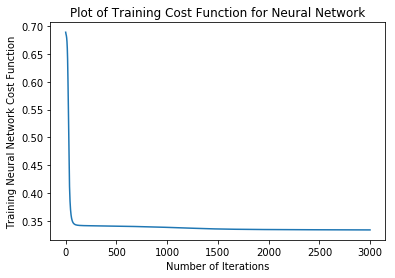

In [18]:
ax = pd.DataFrame(J_history).plot(title= "Plot of Training Cost Function for Neural Network",
                             legend= False)

ax.set_ylabel("Training Neural Network Cost Function")
ax.set_xlabel("Number of Iterations")

Excellent, there is drastic decrease in the cost function and then a clear downward slope as each iteraction of the gradient descent neural network was completed; this indicates that the model was learning with each iteration.

At the end of the 3,000 iterations, the cost of the neural network was $\le$ 0.35. Next I test the trained theta values on the validation set for comparision to the other methods used.

In [19]:
x_validate = features_validate.values # Converting Pandas Data Frame into Matrix
x_validate = np.append(np.ones([len(x_validate), 1]), x_validate, 1) # Adding bias paramter

y_validate = np.matrix(target_validate) # Converting Pandas Data Frame into Matrix
yVec_validate = y_validate.reshape((y_validate.shape[1],1)) 


def predict(Theta1, Theta2, x):
    m = x.shape[0]
    x = np.matrix(x)
    
    layer_z2 = x*Theta1.T # 5000x25, good
    layer_a2 = sigmoid(layer_z2) # 5000x25, good

    layer_a2 = np.append(np.ones([len(layer_a2), 1]), layer_a2, 1) # 5000x26, good

    layer_z3 = layer_a2*Theta2.T # 5000x10
    layer_a3 = sigmoid(layer_z3) # 5000x10
    
    return layer_a3


predictions = predict(Theta1_f, Theta2_f, x_validate).round(0)

print(f"Neural network's accuracy score= {accuracy_score(yVec_validate, predictions) * 100: 0.1f}%", "\n",
      f"Neural network's f1 score= {f1_score(yVec_validate, predictions)}")

Neural network's accuracy score=  80.3% 
 Neural network's f1 score= 0.8181818181818182


## Comparison of Models on Image Classification Task

Next is to create a nice table to easily compare the performance of the difference models on the cancer image classification task.

<table>
  <tr>
    <th>Model Algorithm</th>
    <th>Accuracy Score</th> 
    <th>F1 Score</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>80.3%</td>
    <td>0.8125</td>
  </tr>
  <tr>
    <td>SVM (3k iterations) with <br> C = 24.8, and <br> gamma= 'scale'</td>
    <td>82.0%</td>
    <td>0.8197</td>
  </tr>
  <tr>
    <td>3 Layer Neural Network (3k iterations)<br> w/ sigmoid activation</td>
    <td>80.3%</td>
    <td>0.8182</td>
  </tr>
</table>

The SVM model performed the best in terms of accuracy and F1 score. This model will be selected to be used on the final test set. The accuracy scores are not really desirable for this task given the severity of the problem, but this is a demonstration and is good enough for this purpose.

Some steps that could be taken to improve performance are:
* Increase the number of samples used
    * The current data set had only 303 oservations which were then split into a training set (60% of observations), a validation set (20% of observations), and a test set (20% of observations). The overall sample size was small for this kind of application purpose.
* Could increase the number of layers in the neural network to see if that increase classification performance
* Could try different activation functions, lambda values, scaling parameters, and/or the method of normalization

## The SVM Model on the Final Test Set

In [20]:
clf = svm.SVC(gamma= 'scale', 
              C= 24.8, 
              kernel= 'sigmoid', 
              max_iter= 3000)
clf.fit(features_test, target_test)

SVM_accuracy = accuracy_score(target_test, clf.predict(features_test))
SVM_f1_score = f1_score(target_test, clf.predict(features_test))

print("Using a SVM model, the accuracy achieved on the validation set",
      f"was {SVM_accuracy*100: 0.1f}% and \nthe f1 score was {SVM_f1_score}.")

Using a SVM model, the accuracy achieved on the validation set was  67.2% and 
the f1 score was 0.7142857142857144.


The selected model did not perform well on the final test set. Given the small number of observations, I would first seek to increase the sample size.